# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan. It is not yet the original model as defined by Pierson (2015) and it has only a signle $\sigma$, making it more of a ZI-PPCA, but it's a start.

In [31]:
latent = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    real<lower=0, upper=0.2> lambda; // zero-inflation
    matrix[N,D] x; // non-inflated observations
    vector[D] mu;   //  added means
}

model{
    
    for (d in 1:D){
        target+=normal_lpdf(W[d]|0.0, sigma);
        target+=normal_lpdf(mu[d]|0.0, 5.0) ;
    }
    
    target+=lognormal_lpdf(sigma|0.0, 1.0);
    
    for (n in 1:N){
        target+=normal_lpdf(z[:,n]|0.0,1.0);
        target+=normal_lpdf(x[n]|W*col(z,n)+mu, sigma);
    }
        
    for (n in 1:N){
        for (d in 1:D){
            if (y[n,d]==0){
                target+=bernoulli_lpmf(0|exp(-square(x[n,d])*lambda));
            } else {
                target+=bernoulli_lpmf(1|exp(-square(x[n,d])*lambda));
            }
        }
    }
}
"""
ppca = pystan.StanModel(model_code=latent)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d698058b8ac752dac090f7c20fedd922 NOW.


We specify our parameters and generate some data.

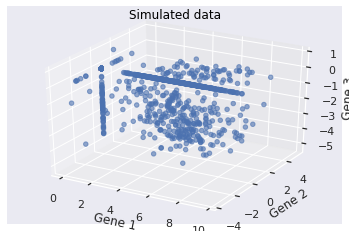

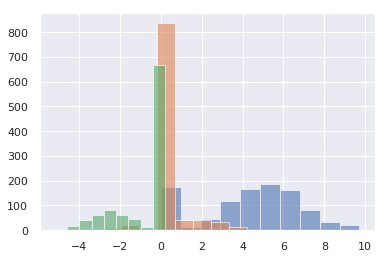

In [32]:
N=1000
M=2
D=3
z = np.random.normal(0,1, size=(N,M))
sigma = np.random.lognormal(0,1)
mu = np.random.normal(0,5,size=D)
lamda = np.random.uniform(low=0,high=0.2)
W = np.random.normal(0,sigma,size=(M,D))
x = np.random.normal(np.matmul(z,W)+mu,sigma)
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.6)
plt.hist(y[:,1], alpha=0.6)
plt.hist(y[:,2], alpha=0.6)
plt.show()

And then we can optimize our parameters and latent dataset.

In [33]:
ppca_dat = {'N': N, 'D':D, 'M':M, 'y':y}
# fit = ppca.sampling(data=ppca_dat, iter=1000, chains=4)
op = ppca.optimizing(data=ppca_dat)

z_sim = op['z'].T
sigma_sim = op['sigma']
lambda_sim = op['lambda']
W_sim = op['W'].T
y_sim = np.random.normal(np.matmul(z_sim,W_sim),sigma_sim)

print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real z: ', z)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('simulated W: ', W_sim)
print()

real sigma:  1.0670581223645996
simulated sigma:  0.025039557143358766

real lambda:  0.11458551875587158
simulated lambda:  0.19999999999999662

real z:  [[ 2.63623246 -1.76761537]
 [ 1.06092598  0.67974236]
 [-0.58085389  1.73964854]
 ...
 [ 0.36240698 -3.15832147]
 [-0.90949129 -0.95373342]
 [-0.45015377  0.56973531]]
simulated z:  [[-0.41574811 -1.89229935]
 [-1.55852367 -0.17540703]
 [ 1.80381258 -0.39265043]
 ...
 [ 0.29824211  1.95935581]
 [ 0.72009596 -1.10598861]
 [-1.72038687  1.51636301]]

real W:  [[-1.46027753 -0.03511062  0.04351393]
 [-0.4254371  -0.72364896  0.29337823]]
simulated W:  [[ 0.10466632  0.58124073  0.74784056]
 [ 0.26992461 -0.80488714  0.46214021]]



The result is plotted below. The result is very strange.

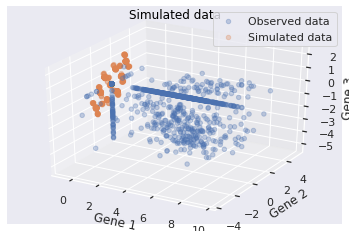

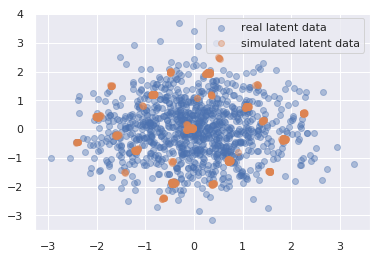

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.3)
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

plt.scatter(z[:,0], z[:,1], label='real latent data', alpha=0.4)
plt.scatter(z_sim[:,0], z_sim[:,1], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()
